In [26]:
import os
import tkinter as tk
from tkinter.colorchooser import askcolor
from tkinter.simpledialog import askstring
from PIL import Image, ImageDraw
import numpy as np
from PIL import Image
from sklearn.neural_network import MLPClassifier
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix
import seaborn as sns
import random

In [27]:
class PaintApp:
    def __init__(self, root, canvas_size=(28, 28), scale=10):
        self.root = root
        self.root.title("Simple Paint App")
        
        # Scale settings
        self.canvas_size = canvas_size
        self.scale = scale
        self.display_size = (canvas_size[0] * scale, canvas_size[1] * scale)

        # Default settings
        self.brush_color = "black"
        self.brush_size = 20  # This is the display brush size
 
        # Set up Canvas
        self.canvas = tk.Canvas(root, bg="white", width=self.display_size[0], height=self.display_size[1])
        self.canvas.pack()

        # Set up PIL image to draw on and save later (true 28x28 resolution)
        self.image = Image.new("RGB", self.canvas_size, "white")
        self.draw = ImageDraw.Draw(self.image)

        # Canvas bindings
        self.canvas.bind("<B1-Motion>", self.paint)
        self.canvas.bind("<Button-1>", self.paint)  # Allow single clicks to paint
        
        # Set up UI for color and brush size
        self.setup_ui()

    def setup_ui(self):
        # Label input
        self.label_button = tk.Button(self.root, text="Set Label", command=self.set_label)
        self.label_button.pack(side="left")

        # Color button
        color_button = tk.Button(self.root, text="Choose Color", command=self.choose_color)
        color_button.pack(side="left")

        # Clear button
        clear_button = tk.Button(self.root, text="Clear", command=self.clear_canvas)
        clear_button.pack(side="left")

        # Save button
        save_button = tk.Button(self.root, text="Save", command=self.save_image)
        save_button.pack(side="left")

        # Default label
        self.label = "image"

    def set_label(self):
        label = askstring("Set Label", "Enter label for image filename:")
        if label:
            self.label = label
            print(f"Label set to '{self.label}'")

    def choose_color(self):
        color = askcolor(color=self.brush_color)[1]
        if color:
            self.brush_color = color

    def paint(self, event):
        # Calculate scaled-down coordinates for the 28x28 image
        scaled_x, scaled_y = int(event.x / self.scale), int(event.y / self.scale)

        # Draw on the displayed canvas (scaled-up, with ovals)
        x, y = event.x, event.y
        r = self.brush_size / 2
        self.canvas.create_oval(x - r, y - r, x + r, y + r, fill=self.brush_color, outline="")

        # Draw a smaller oval on the 28x28 PIL image to represent the scaled effect
        scaled_r = max(1, int(r / self.scale))  # Ensure the brush size is at least 1 in the 28x28 scale
        self.draw.ellipse([scaled_x - scaled_r, scaled_y - scaled_r, scaled_x + scaled_r, scaled_y + scaled_r], fill=self.brush_color)

    def clear_canvas(self):
        # Clear the tkinter canvas
        self.canvas.delete("all")
        # Clear the 28x28 PIL image
        self.draw.rectangle([0, 0, *self.canvas_size], fill="white")

    def save_image(self):
        # Save the 28x28 image with the specified label
        img_number = 1
        filename = f"data/{self.label}_{img_number}.png"
        
        # Ensure filename is unique
        while os.path.exists(filename):
            img_number += 1
            filename = f"data/{self.label}_{img_number}.png"
        
        # Make directory if it doesn't exist
        os.makedirs("data", exist_ok=True)

        self.image.save(filename)
        print(f"Image saved as {filename}")

        self.clear_canvas()

# Run the application
root = tk.Tk()
app = PaintApp(root)
root.mainloop()


X shape: (354, 784)
y shape: (354,)
Training data shape: (283, 784)
Testing data shape: (71, 784)
0.7746478873239436


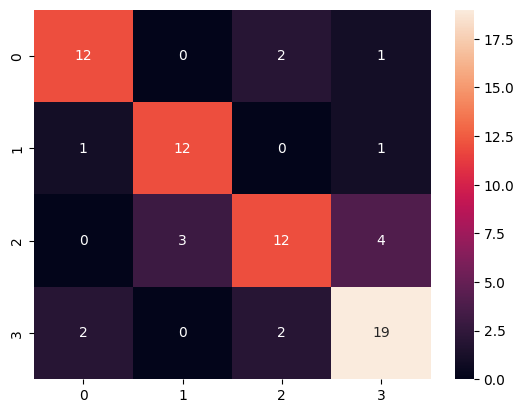

Correct predictions:


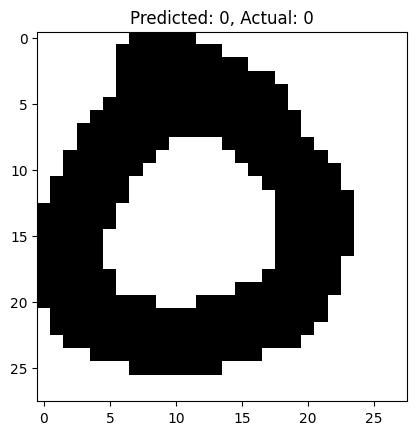

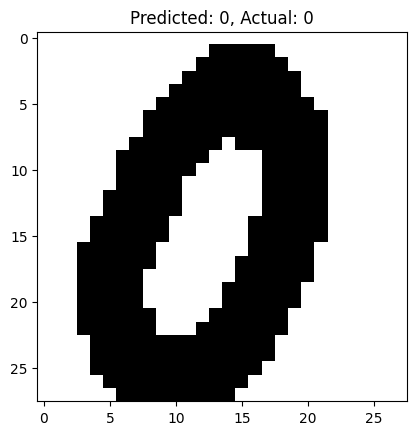

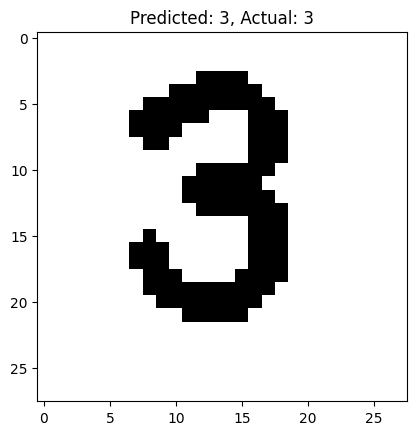

Incorrect predictions:


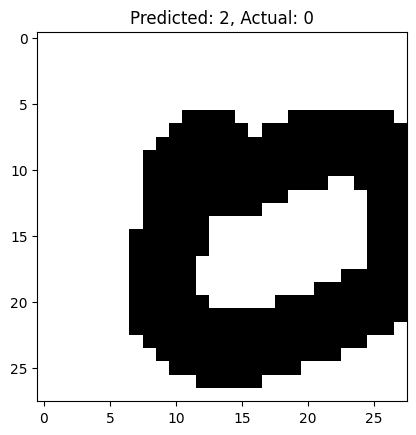

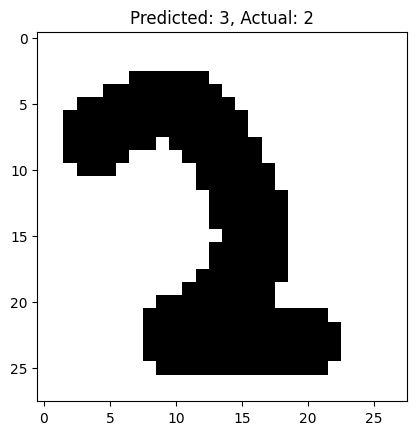

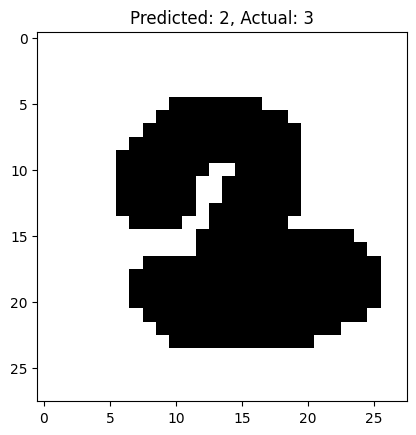

In [28]:
# load in digit pngs (labeld as 0_1, 0_2, 0_3.png etc where the first is the label) of 32x32 pixels and convert them to 1D numpy arrays

def load_data():
    data = []
    labels = []
    for file in os.listdir("data"):
        if file.endswith(".png"):
            img = Image.open("data/" + file)
            img = img.convert("L")
            img = img.resize((28, 28))
            img = np.array(img)
            img = img.flatten()
            data.append(img)
            labels.append(int(file.split("_")[0]))
    data = np.array(data)
    labels = np.array(labels)
    return data, labels

data, labels = load_data()

print("X shape:", data.shape)
print("y shape:", labels.shape)

# Create sklearn neural network to classify the digits
X_train_custom, X_test_custom, y_train_custom, y_test_custom = train_test_split(data, labels, test_size=0.2)

# Normalize the data
X_train_custom = X_train_custom / 255
X_test_custom = X_test_custom / 255

print("Training data shape:", X_train_custom.shape)
print("Testing data shape:", X_test_custom.shape)

clf = MLPClassifier(hidden_layer_sizes=(128,), max_iter=1000)
clf.fit(X_train_custom, y_train_custom)

print(clf.score(X_test_custom, y_test_custom))

# Show confusion matrix
y_pred_custom = clf.predict(X_test_custom)
cm = confusion_matrix(y_test_custom, y_pred_custom)
sns.heatmap(cm, annot=True, fmt="d")
plt.show()

print("Correct predictions:")

# Show some correct predictions and the actual images and label
correct = 0
attempts = 0
while correct < 3 and attempts < 100:
    index = random.randint(0, len(X_test_custom) - 1)
    pred = clf.predict([X_test_custom[index]])
    if pred == y_test_custom[index]:
        correct += 1
        img = X_test_custom[index].reshape(28, 28)
        plt.imshow(img, cmap="gray")
        plt.title(f"Predicted: {pred[0]}, Actual: {y_test_custom[index]}")
        plt.show()

print("Incorrect predictions:")

# Show some incorrect predictions and the actual images and label
incorrect = 0
attempts = 0
while incorrect < 3 and attempts < 100:
    index = random.randint(0, len(X_test_custom) - 1)
    pred = clf.predict([X_test_custom[index]])
    if pred != y_test_custom[index]:
        incorrect += 1
        img = X_test_custom[index].reshape(28, 28)
        plt.imshow(img, cmap="gray")
        plt.title(f"Predicted: {pred[0]}, Actual: {y_test_custom[index]}")
        plt.show()


Epoch 1/40


c:\Users\kflin\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4413 - loss: 24.8612 - val_accuracy: 0.6620 - val_loss: 1.4299
Epoch 2/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6645 - loss: 1.3071 - val_accuracy: 0.6761 - val_loss: 0.7733
Epoch 3/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8007 - loss: 0.5101 - val_accuracy: 0.8028 - val_loss: 0.5428
Epoch 4/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8897 - loss: 0.2705 - val_accuracy: 0.8732 - val_loss: 0.3860
Epoch 5/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8659 - loss: 0.3265 - val_accuracy: 0.8732 - val_loss: 0.3300
Epoch 6/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9530 - loss: 0.1815 - val_accuracy: 0.9014 - val_loss: 0.2846
Epoch 7/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9479 - loss: 0.1484 - val_accuracy: 0.9014 - val_loss: 0.3122
Epoch 8/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9802 - loss: 0.0985 - val_accuracy: 0.8873 - val_loss: 0.3718
Ep

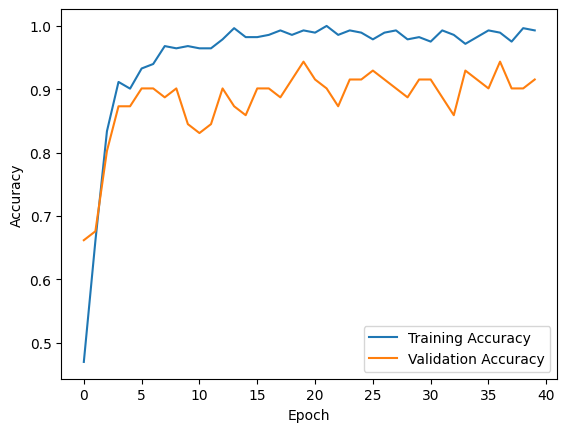

1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/stepWARNING:tensorflow:6 out of the last 9 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x000001EAE8A13560> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


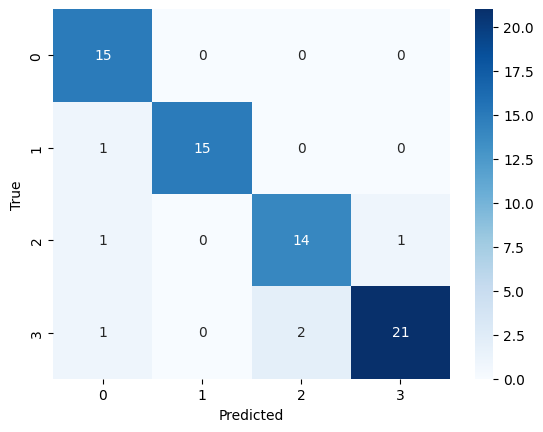

Correct predictions:


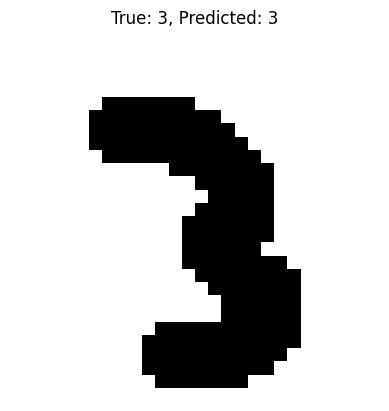

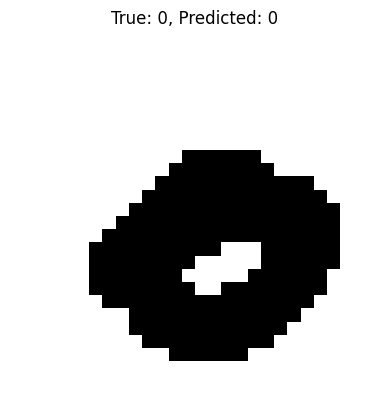

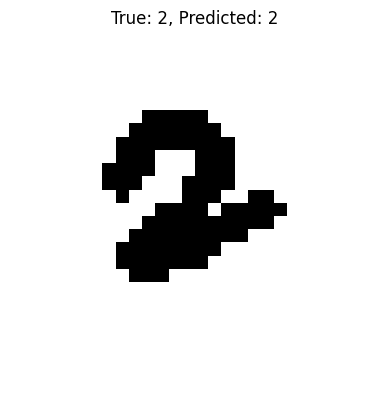

Incorrect predictions:


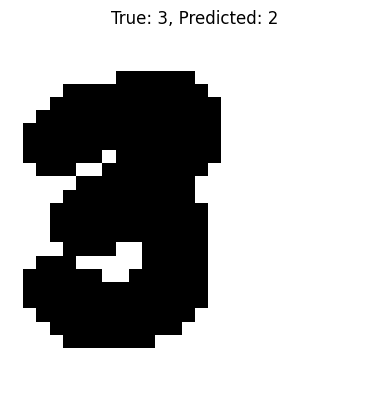

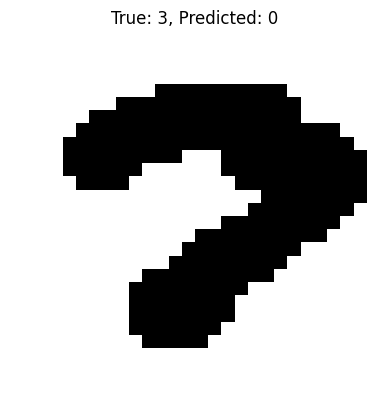

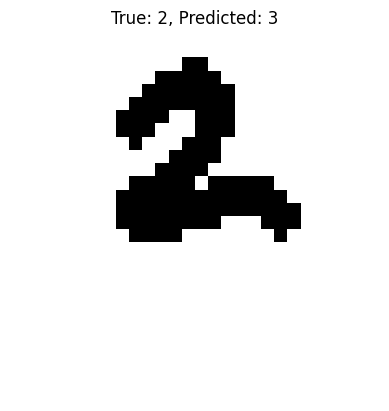

In [30]:
# Reshape data for CNN
data_cnn = data.reshape(-1, 28, 28, 1)  # Add channel dimension for grayscale images
labels_cnn = to_categorical(labels, num_classes=4)  # One-hot encode labels for 4 classes (0, 1, 2, 3)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(data_cnn, labels_cnn, test_size=0.2, stratify=labels)

# Build the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(4, activation='softmax')  # Output layer for 4 classes
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=40, validation_data=(X_test, y_test), batch_size=8)

# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc}")

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

# Generate predictions and display a confusion matrix
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred_classes)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0,1,2,3], yticklabels=[0,1,2,3])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Show some correct and incorrect predictions
def plot_sample(X, y, y_pred):
    plt.imshow(X.reshape(28, 28), cmap="gray")
    plt.title(f"True: {y}, Predicted: {y_pred}")
    plt.axis("off")
    plt.show()

# Show some correct predictions
print("Correct predictions:")
correct = np.where(y_true == y_pred_classes)[0]
for i in range(min(3, len(correct))):
    idx = correct[i]
    plot_sample(X_test[idx], y_true[idx], y_pred_classes[idx])

# Show some incorrect predictions
print("Incorrect predictions:")
incorrect = np.where(y_true != y_pred_classes)[0]
for i in range(min(3, len(incorrect))):
    idx = incorrect[i]
    plot_sample(X_test[idx], y_true[idx], y_pred_classes[idx])